In [1]:
import pandas as pd
import numpy as np
import re
import string

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

In [3]:
lemmatizer = WordNetLemmatizer()

In [4]:
with open('Health-Tweets/bbchealth.txt') as file:
    contents = file.readlines()
    
# Fancy regex for extracting data. Because I'm awesome and I refuse to split it.
regex = re.compile(r'(?P<tweet_id>.*)\|(?P<date>.*)\|(?P<news>.*)\s?(?P<link>http://.*)')

In [5]:
re.search(regex, contents[0]).groupdict()

{'tweet_id': '586266687948881921',
 'date': 'Thu Apr 09 20:37:25 +0000 2015',
 'news': 'Drugs need careful monitoring for expiry dates, pharmacists say ',
 'link': 'http://www.cbc.ca/news/health/drugs-need-careful-monitoring-for-expiry-dates-pharmacists-say-1.3026749?cmp=rss'}

In [24]:
df = pd.DataFrame(columns=['tweet_id', 'date', 'news', 'link'])

for line in contents:
    line_data = re.search(regex, line).groupdict()
    df = df.append(line_data, ignore_index=True)

In [8]:
df.head()

,tweet_id,date,news,link
0,586266687948881921,Thu Apr 09 20:37:25 +0000 2015,Drugs need careful monitoring for expiry dates...,http://www.cbc.ca/news/health/drugs-need-caref...
1,586266687017771008,Thu Apr 09 20:37:25 +0000 2015,Sabra hummus recalled in U.S.,http://www.cbc.ca/news/health/sabra-hummus-rec...
2,586266685495214080,Thu Apr 09 20:37:24 +0000 2015,U.S. sperm bank sued by Canadian couple didn't...,http://www.cbc.ca/news/canada/toronto/sperm-ba...
3,586226316820623360,Thu Apr 09 17:57:00 +0000 2015,Manitoba pharmacists want clampdown on Tylenol...,http://www.cbc.ca/news/canada/manitoba/manitob...
4,586164344452354048,Thu Apr 09 13:50:44 +0000 2015,Mom of 7 'spooked' by vaccinations reverses st...,http://www.cbc.ca/news/canada/ottawa/tara-hill...


In [9]:
def normalize(line):
    line = line.lower().strip()
    line = ''.join([char for char in line if char not in string.punctuation+string.digits])
    return word_tokenize(line)

# Lemmatizing each word in each line
def lemmatize_sent(line_tokens):
    return list(map(lemmatizer.lemmatize, line_tokens))

# POS tagging, This one returns just the POS tags in order.
def tokens(line_tokens):
    word_tags = pos_tag(line_tokens)
    return list(zip(*word_tags))[1]

In [10]:
df['news_tokens'] = df['news'].map(normalize)
df['corresponding_tags'] = df['news_tokens'].map(tokens)
df['lemmatized_news_tokens'] = df['news_tokens'].map(lemmatize_sent)

In [11]:
df.drop(labels=['link'], inplace=True, axis=1)
df.drop(labels=['tweet_id'], inplace=True, axis=1)

In [12]:
df.head()

,date,news,news_tokens,corresponding_tags,lemmatized_news_tokens
0,Thu Apr 09 20:37:25 +0000 2015,Drugs need careful monitoring for expiry dates...,"[drugs, need, careful, monitoring, for, expiry...","(NNS, VBP, JJ, NN, IN, JJ, NNS, NNS, VBP)","[drug, need, careful, monitoring, for, expiry,..."
1,Thu Apr 09 20:37:25 +0000 2015,Sabra hummus recalled in U.S.,"[sabra, hummus, recalled, in, us]","(NN, NN, VBN, IN, PRP)","[sabra, hummus, recalled, in, u]"
2,Thu Apr 09 20:37:24 +0000 2015,U.S. sperm bank sued by Canadian couple didn't...,"[us, sperm, bank, sued, by, canadian, couple, ...","(PRP, VBP, NN, VBN, IN, JJ, NN, NN, NN, NN, NN...","[u, sperm, bank, sued, by, canadian, couple, d..."
3,Thu Apr 09 17:57:00 +0000 2015,Manitoba pharmacists want clampdown on Tylenol...,"[manitoba, pharmacists, want, clampdown, on, t...","(NN, NNS, VBP, VBN, IN, NN, NNS)","[manitoba, pharmacist, want, clampdown, on, ty..."
4,Thu Apr 09 13:50:44 +0000 2015,Mom of 7 'spooked' by vaccinations reverses st...,"[mom, of, spooked, by, vaccinations, reverses,...","(NN, IN, VBN, IN, NNS, NNS, VBP, NNS, CC, RB, ...","[mom, of, spooked, by, vaccination, revers, st..."


In [13]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized_news_tokens'].map(lambda x: ' '.join(x)).tolist())

In [14]:
kmeans = KMeans()
kmeans.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [16]:
tfidf_matrix

<313x1382 sparse matrix of type '<class 'numpy.float64'>'
	with 2885 stored elements in Compressed Sparse Row format>

In [17]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

(-0.4, 0.4)

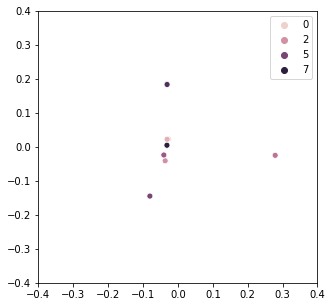

In [18]:
plt.figure(figsize=(5, 5))
cluster_centers = pca.fit_transform(kmeans.cluster_centers_)
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], hue=np.unique(kmeans.labels_))
    
plt.xlim((-0.4, 0.4))
plt.ylim((-0.4, 0.4))

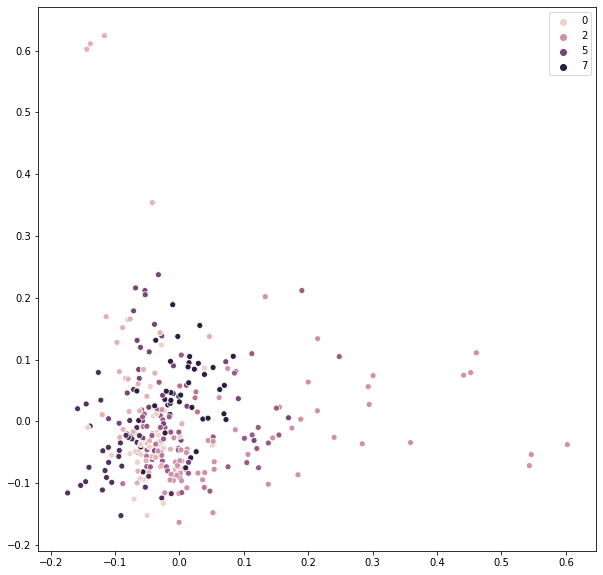

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=kmeans.labels_)

In [20]:
pca_3d = PCA(n_components=3)
pca_matrix_3d = pca_3d.fit_transform(tfidf_matrix.A)

/Users/rishik/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


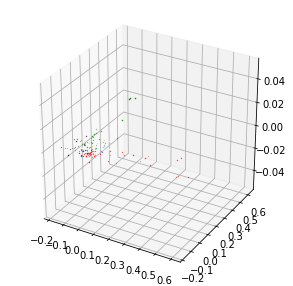

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
for p, l in zip(pca_matrix_3d, kmeans.labels_):
    plt.scatter(*p, 'bgrcmykw'[l])

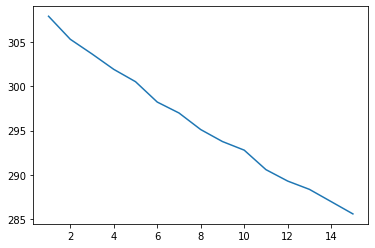

In [22]:
x, y = [], []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    x.append(k)
    y.append(kmeans.inertia_)
    
plt.plot(x, y)

In [23]:
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    sil_score = silhouette_score(tfidf_matrix, kmeans.labels_)
    print('Number of clusters: {}, Silhoutte Score: {}'.format(k, sil_score))

Number of clusters: 2, Silhoutte Score: 0.0034380139250351255
Number of clusters: 3, Silhoutte Score: 0.0034428238872550904
Number of clusters: 4, Silhoutte Score: 0.004723416155939683
Number of clusters: 5, Silhoutte Score: 0.004284734845238452
Number of clusters: 6, Silhoutte Score: 0.004543388650879241
Number of clusters: 7, Silhoutte Score: 0.004575979072587933
Number of clusters: 8, Silhoutte Score: 0.005214828861675747
Number of clusters: 9, Silhoutte Score: 0.00550070673478392
Number of clusters: 10, Silhoutte Score: 0.00514573551614799
Number of clusters: 11, Silhoutte Score: 0.005372463785960672
Number of clusters: 12, Silhoutte Score: 0.007067727311830242
Number of clusters: 13, Silhoutte Score: 0.006169624484938028
Number of clusters: 14, Silhoutte Score: 0.005887202026369849
Number of clusters: 15, Silhoutte Score: 0.006366753205572386
